In [1]:
CHARACTER = "МОНИКА"

main_characters = ['ДЖОУИ', 'МОНИКА', 'РЕЙЧЕЛ', 'РОСС', 'ФИБИ', 'ЧЕНДЛЕР']
labels_to_chars = dict(enumerate(main_characters))
chars_to_labels = {v: k for k, v in labels_to_chars.items()}
labels_to_chars, chars_to_labels

({0: 'ДЖОУИ', 1: 'МОНИКА', 2: 'РЕЙЧЕЛ', 3: 'РОСС', 4: 'ФИБИ', 5: 'ЧЕНДЛЕР'},
 {'ДЖОУИ': 0, 'МОНИКА': 1, 'РЕЙЧЕЛ': 2, 'РОСС': 3, 'ФИБИ': 4, 'ЧЕНДЛЕР': 5})

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/Alenush/style_transfer_sirius2021summer.git

Cloning into 'style_transfer_sirius2021summer'...
remote: Enumerating objects: 1795, done.
remote: Counting objects: 100% (1795/1795), done.
remote: Compressing objects: 100% (1131/1131), done.
remote: Total 1795 (delta 811), reused 1614 (delta 637), pack-reused 0
Receiving objects: 100% (1795/1795), 52.60 MiB | 14.35 MiB/s, done.
Resolving deltas: 100% (811/811), done.
Checking out files: 100% (657/657), done.


In [4]:
%%bash

cd style_transfer_sirius2021summer
git checkout master
git pull
cd -

Branch 'master' set up to track remote branch 'master' from 'origin'.
Already up to date.
/content


Switched to a new branch 'master'


In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm

tqdm.pandas()

In [6]:
#!g1.1
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [7]:
#!g1.1
df = pd.read_csv("style_transfer_sirius2021summer/data/train_data/en/only_unique_phrases_eng.csv")
df

,label,sentence,base_sentence
0,0,"Hey, you've traveled a lot right?",hey youve travel a lot right
1,1,"But, we pick again!",but we pick again
2,5,"Ok, ok, you can be shirts and I'll be skins.",ok ok you can be shirt and be skin
3,3,"Oh, but he will.",oh but he will
4,2,"Whoa, that Diet Coke just went straight to my ...",whoa that just go straight to my head
...,...,...,...
59291,0,"Ross, Ross, over here man.",over here man
59292,3,"Uhh, it was fun.",uhh it be fun
59293,5,"Okay, I'll give them back.",okay give them back
59294,5,"Well, thats not true, hehe smacked you once.",well thats not true hehe smack you once


In [8]:
df_person = df.copy()
idx = chars_to_labels[CHARACTER]
df_person["label"] = df_person["label"].progress_apply(lambda x: 1 if x == idx else 0)
df_person

100%|██████████| 59296/59296 [00:00<00:00, 635342.48it/s]


,label,sentence,base_sentence
0,0,"Hey, you've traveled a lot right?",hey youve travel a lot right
1,1,"But, we pick again!",but we pick again
2,0,"Ok, ok, you can be shirts and I'll be skins.",ok ok you can be shirt and be skin
3,0,"Oh, but he will.",oh but he will
4,0,"Whoa, that Diet Coke just went straight to my ...",whoa that just go straight to my head
...,...,...,...
59291,0,"Ross, Ross, over here man.",over here man
59292,0,"Uhh, it was fun.",uhh it be fun
59293,0,"Okay, I'll give them back.",okay give them back
59294,0,"Well, thats not true, hehe smacked you once.",well thats not true hehe smack you once


In [9]:
import re

df_person["not_alpha_num_punct"] = df_person["sentence"].apply(lambda x: bool(re.match(r"[A-Za-z0-9 _.,!\"\'/$]*", x)))
df_person

,label,sentence,base_sentence,not_alpha_num_punct
0,0,"Hey, you've traveled a lot right?",hey youve travel a lot right,True
1,1,"But, we pick again!",but we pick again,True
2,0,"Ok, ok, you can be shirts and I'll be skins.",ok ok you can be shirt and be skin,True
3,0,"Oh, but he will.",oh but he will,True
4,0,"Whoa, that Diet Coke just went straight to my ...",whoa that just go straight to my head,True
...,...,...,...,...
59291,0,"Ross, Ross, over here man.",over here man,True
59292,0,"Uhh, it was fun.",uhh it be fun,True
59293,0,"Okay, I'll give them back.",okay give them back,True
59294,0,"Well, thats not true, hehe smacked you once.",well thats not true hehe smack you once,True


In [10]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 12.5 MB/s 
     |████████████████████████████████| 636 kB 39.5 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 3.3 MB 37.6 MB/s 
     |████████████████████████████████| 895 kB 38.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
df_person[df_person["label"] == 1]

,label,sentence,base_sentence,not_alpha_num_punct
1,1,"But, we pick again!",but we pick again,True
6,1,They thought Joey was a child?,they thought be a child,True
10,1,I'm your Aunt Monica.,im your,True
11,1,I wouldnt want my best guest to strain her eyes!,i wouldnt want my best guest to strain her eye,True
13,1,"And Nancy said that it's really under price, b...",and say that it really under price because th...,True
...,...,...,...,...
59257,1,"What, he doesn't like Josh?",what he doesnt like,True
59258,1,If you're too afraid to be in a real relations...,if youre too afraid to be in a real relationsh...,True
59279,1,You're shivering.,youre shiver,True
59285,1,Im gonna make this up to you.,im gon na make this up to you,True


In [12]:
f"Negative = {round(100 * df_person[df_person['label'] == 0].shape[0] / df_person.shape[0])}%"

'Negative = 84%'

In [13]:
df_pos_ = df_person[df_person['label'] == 1]
df_pos_ = df_pos_.sample(df_pos_.shape[0]).reset_index(drop=True)
df_pos_

,label,sentence,base_sentence,not_alpha_num_punct
0,1,Heads!,heads,True
1,1,"Okay, let's let the Alanbashing begin.",okay let let the alanbashing begin,True
2,1,"It's nice, and, we're having fun.",its nice and be have fun,True
3,1,"Okay, so you were trying to play bad this whol...",okay so you be try to play bad this whole time,True
4,1,Youre wrong!,youre wrong,True
...,...,...,...,...
9364,1,"Chandler usually helps me with this, but hes r...",usually help me with this but he really into t...,True
9365,1,I think he is fine!,i think he be fine,True
9366,1,"Our, our friends lost a monkey.",our our friend lose a monkey,True
9367,1,"Oh my god, oh my god, oh my god!",oh my god oh my god oh my god,True


In [14]:
df_neg_ = df_person[df_person['label'] == 0].sample(df_pos_.shape[0] // 3).reset_index(drop=True)
df_neg_

,label,sentence,base_sentence,not_alpha_num_punct
0,0,"Oh uh, hey.",oh uh hey,True
1,0,Crazy lady thinks her mother is in a cat.,crazy lady think her mother be in a cat,True
2,0,"Come here, here, come here, come here, Mrs. Bu...",come here here come here come here,True
3,0,This is so your fault.,this be so your fault,True
4,0,Wish it!,wish it,True
...,...,...,...,...
3118,0,Are we just gonna go ahead and set them up wit...,are we just gon na go ahead and set them up wi...,True
3119,0,How do you think this suit would look on an as...,how do you think this suit would look on an as...,True
3120,0,"Its left sweetie, but thats okay sweetie, that...",its left sweetie but thats okay sweetie thats ...,True
3121,0,"Oh, come on people come on, now, if I don't kn...",oh come on people come on now if i dont know w...,True


In [15]:
result = pd.concat([df_pos_, df_neg_])
df_person = result.sample(n=result.shape[0]).reset_index(drop=True)[["sentence", "label"]]
df_person

,sentence,label
0,What I said.,0
1,"Wait, here's one.",0
2,Let's forget about this going home stuff and c...,1
3,All weekend?,1
4,"So uh, how are you guys doing?",0
...,...,...
12487,Why is it sick?,1
12488,Places like are always shakin you down.,1
12489,"Yeah, you were, but you decided to make salmon...",1
12490,That's excellent.,0


In [16]:
sentences = df_person.sentence.values
labels = df_person.label.values

In [17]:
from collections import Counter

Counter(labels)

Counter({0: 3123, 1: 9369})

In [18]:
n = 0
sents = []
lbls = []
for sent, label in zip(sentences, labels):
    if label == 1:
      while n != 3123:
          n += 1
          lbls.append(label)
          sents.append(sent)
    else:
        lbls.append(label)
        sents.append(sent)

print(len(sents), len(lbls))
Counter(lbls)

6246 6246


Counter({0: 3123, 1: 3123})

In [19]:
from sklearn.utils import shuffle

sentences, labels = shuffle(sents, lbls)
print(labels)

[0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 

In [20]:
from transformers import BertTokenizer
# using the low level BERT for our task.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Printing the original sentence.
print('Original: ', sentences[0])

# Printing the tokenized sentence in form of list.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))
print(labels[0])

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Original:  Actually, I think this apartment sullies the good name of crap.
Tokenized:  ['actually', ',', 'i', 'think', 'this', 'apartment', 'sul', '##lies', 'the', 'good', 'name', 'of', 'crap', '.']
Token IDs:  [2941, 1010, 1045, 2228, 2023, 4545, 21396, 11983, 1996, 2204, 2171, 1997, 10231, 1012]
0


In [21]:
input_ids = []
for sent in sentences:
    # so basically encode tokenizing , mapping sentences to thier token ids after adding special tokens.
    encoded_sent = tokenizer.encode(
        sent,                      # Sentence which are encoding.
        add_special_tokens = True, # Adding special tokens '[CLS]' and '[SEP]'
    )
    input_ids.append(encoded_sent)

In [22]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 128
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN , truncating="post", padding="post")

In [23]:
attention_masks = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [24]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.2)

In [25]:
#changing the numpy arrays into tensors for working on GPU. 
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Deciding the batch size for training.
batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation(test) set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [41]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Running the model on GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [42]:
optimizer = AdamW(
    model.parameters(),
    lr = 1e-7,
    weight_decay=1e-5, # L2 Regularization
    eps = 1e-8 
)

In [43]:
#!g1.1
from transformers import get_linear_schedule_with_warmup
import time

epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [44]:
from tqdm import trange

import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [45]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        output = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask, 
                      labels=b_labels
        )

        loss = output.loss
        total_train_loss += loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            output = model(
                b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask,
                labels=b_labels
            )
            
        # Accumulate the validation loss.
        loss = output.loss
        logits = output.logits
        total_eval_loss += loss
        
        label_ids = b_labels.cpu().numpy()
        logits = logits.detach().cpu().numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("Validation Loss: {0:.2f}".format(avg_val_loss))
    print("Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    157.    Elapsed: 0:00:49.
  Batch    80  of    157.    Elapsed: 0:01:38.
  Batch   120  of    157.    Elapsed: 0:02:27.

  Average training loss: 0.68
  Training epcoh took: 0:03:12

Running Validation...
  Accuracy: 0.80
Validation Loss: 0.65
Validation took: 0:00:17

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    157.    Elapsed: 0:00:49.
  Batch    80  of    157.    Elapsed: 0:01:38.
  Batch   120  of    157.    Elapsed: 0:02:27.

  Average training loss: 0.65
  Training epcoh took: 0:03:12

Running Validation...
  Accuracy: 0.88
Validation Loss: 0.62
Validation took: 0:00:17

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    157.    Elapsed: 0:00:49.
  Batch    80  of    157.    Elapsed: 0:01:39.
  Batch   120  of    157.    Elapsed: 0:02:28.

  Average training loss: 0.63
  Training epcoh took: 0:03:13

Running Validation...
  Accuracy: 0.89
Validation Loss: 0.61
Validation took: 0:00:17



In [46]:
chars_ru2en = {
    'ДЖОУИ'  : 'Joey',
    'МОНИКА' : 'Monica',
    'РЕЙЧЕЛ' : 'Rachel',
    'РОСС'   : 'Ross',
    'ФИБИ'   : 'Phoebe',
    'ЧЕНДЛЕР': 'Chandler',
}

In [47]:
chars_ru2en

{'ДЖОУИ': 'Joey',
 'МОНИКА': 'Monica',
 'РЕЙЧЕЛ': 'Rachel',
 'РОСС': 'Ross',
 'ФИБИ': 'Phoebe',
 'ЧЕНДЛЕР': 'Chandler'}

In [48]:
import pathlib

# The name of the task to train.I'm going to name this 'yelp'.
TASK_NAME = f'en-{chars_ru2en[CHARACTER].lower()}'

ROOT_DIR = '/content/drive/MyDrive/FriendsClassifiers'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'{ROOT_DIR}/outputs/{TASK_NAME}/'
pathlib.Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

CONFIG_NAME = "config.json"
WEIGHTS_NAME = f"{TASK_NAME}-pytorch_model.bin"
print(WEIGHTS_NAME)

en-monica-pytorch_model.bin


In [49]:
import os
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(OUTPUT_DIR, WEIGHTS_NAME)
output_config_file = os.path.join(OUTPUT_DIR, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(OUTPUT_DIR)

('/content/drive/MyDrive/FriendsClassifiers/outputs/en-monica/vocab.txt',)

In [62]:
loss_values = [float(stat['Training Loss'].cpu().detach().numpy()) for stat in training_stats]
loss_values

[0.6809882521629333, 0.653809130191803, 0.63311368227005]

(0.6091763973236084, 0.704925537109375)

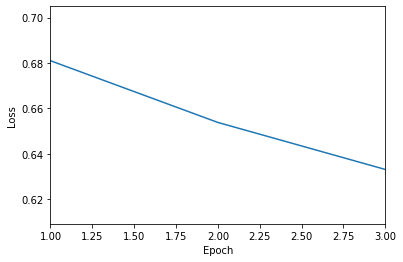

In [63]:
from matplotlib import pyplot as plt

plt.plot(range(1, epochs + 1), loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(1, epochs)

loss_min = min(loss_values)
loss_max = max(loss_values)
variance = loss_max - loss_min
limit_min = loss_min - variance * 0.5
limit_max = loss_max + variance * 0.5
plt.ylim(limit_min, limit_max)